In [ ]:
% cd /content/drive/MyDrive/BDOS

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
import bdos_scripts as bdos
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

BATCH_SIZE = 64
WEIGHTS_PATH = '/content/drive/MyDrive/BDOS/weights'
plt.style.use('ggplot')

/content/drive/MyDrive/BDOS


# Intro

The goal of the project is to detect whether a cell is parasitized (causing Malaria) or healthy. This goal can be achieved by a classical binary classification, but here, instead, an anomaly detection approach will be shown. Deep neural networks can perform anomaly detection tasks by using an autoencoder architecture that by learning important features of healthy data allows us to detect anomalies in a way that will be described in the following sections. \\
The advantage of the anomaly detection is that this method can be trained on only one class ( usefull when anomalies are rare events and a binary classifier can not be trained easily) and also they can highlight in which part of the data the anomaly can be found.
In this dataset it is always possible to recognize by naked eye where the anomaly is located and this is also the reason why it was chosen, nonetheless the same approach can be applied to also other tasks where the anomaly is harder to identify. \\
At the end also a minimal interpretability of the autoencoder's latent space will be done, by showing that the first principal component in the latent space modulates the color of the cell.

# Data pre-processing

The dataset is available in the tensorflow collection, it contains cell images from two classe: healthy and parasitized. They are RGB images and can be found here: https://www.tensorflow.org/datasets/catalog/malaria?hl=en \\
Examples of the dataset will be shown in the following cells.

Dataset loading:

In [ ]:
data = tfds.load('malaria', as_supervised=True, 
                 shuffle_files=False)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteGGJZG0/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


Input pipeline functions:

In [ ]:
def img_processing(img):
    '''
        Pre-processing function:
        Scale the image in the range 0,1 and resize to 64x64.
    '''
    img = tf.cast(img, tf.float32)  / 255.0
    img = tf.image.resize(img, size = (64,64))
    return img

def filter_zero_fun(x,y):
    '''
        True or false wether the target is equal to 0.
        Needed to select only the healthy cells.
    '''
    return tf.math.equal(y, 0)

def filter_one_fun(x,y):
    '''
        True or false wether the target is equal to 1.
        Needed to select only the parasitized cells.
    '''
    return tf.math.equal(y, 1)

The data pre-processing is minimum, just a normalization in the range $[0,1]$ and a rescale into 64x64 to simplify the problem.

Creation of the input pipeline through the use of the dataset object.
The "filter" functions are applied to select only healthy or parasitized
data. 

In [ ]:
train_data = data['train'].skip(BATCH_SIZE*10).filter(filter_one_fun).map(lambda x,y: (img_processing(x), img_processing(x)))
val_data_healthy = data['train'].take(BATCH_SIZE*10).filter(filter_one_fun).map(lambda x,y: img_processing(x))
val_data_malaria = data['train'].take(BATCH_SIZE*10).filter(filter_zero_fun).map(lambda x,y: img_processing(x))

train_data = train_data.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

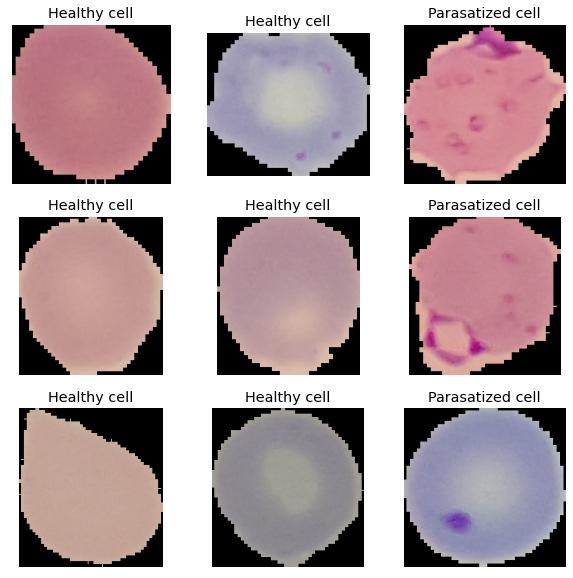

In [ ]:
#@title Data examples
plt.figure(figsize=(10,10))
for idx, obs in enumerate(data['train']):
    plt.subplot(3,3,idx+1)
    plt.imshow(obs[0])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if obs[1] == 1:
        plt.title('Healthy cell')
    else:
        plt.title('Parasatized cell')
    if idx==8:
        break

From above it is possible to notice that the cells come in different shapes and specially colors, feature that will be relevant in the last section of the report.

# The Autoencoder

Autoencoders are a type of neural network architecture formed by two parts: Encoder and Decoder. The former encodes the input image of dimension $(n,n)$ into a latent vector of dimension $p$. The Decoder instead converts the $p$ dimensional vector back to an $(n,n)$ dimensional image. The final objective is to reconstruct the original image and the training is performed by minimizing a loss function between the original image and the reconstructed one. The general idea is that the data is encoded into a lower dimensional space where some information is surely lost and in it the network should learn how to embed the important features to be able after to reconstruct it through the decoder. There are several ways to build an autoencoder, here the encoder will be built by using mainly convolutional layers and the decoder by mainly transposed convolutional layer and the latent vector would be a single vector of dimension $(1,p)$. \\
Since the data here are images one can also think to encode them into smaller images, but as shown by Baur et al. 2020 (https://arxiv.org/pdf/2004.03271.pdf) dense latent vectors performed better than images.

The overall architecture was inspired by the Baur et al. one. 

In [ ]:
#@title Layers and model code
class ConvBlock(tf.keras.layers.Layer):

    '''
        Fundamental block of the encoder, formed by conv layers
        with stride 2 and leaky relu as activation function.
    '''

    def __init__(self, num_filters,filter_size = 5, 
                 stride_size = 2, batch_norm = False):
        super(ConvBlock, self).__init__()
        self.conv_layer = layers.Conv2D(num_filters, kernel_size = filter_size,
                                        padding='SAME', strides=stride_size)
        self.activation = layers.LeakyReLU()
        self.bn = layers.BatchNormalization()
        self.batch_norm = batch_norm

    def call(self, inputs):
        x = self.conv_layer(inputs)
        if self.batch_norm:
            x = self.bn(x)
        return  self.activation(x)


class DeConvBlock(tf.keras.layers.Layer):

    '''
        Fundamental block of the decoder, formed by conv transposed
        layers with stride 2 and leaky relu as activation function.
    '''
    def __init__(self, num_filters,filter_size = 5, 
                 stride_size = 2,batch_norm = False):
        super(DeConvBlock, self).__init__()
        self.conv_layer = layers.Conv2DTranspose(num_filters, 
                                                 kernel_size = filter_size,
                                                 strides = stride_size, 
                                                 padding='SAME')
        self.activation = layers.LeakyReLU()
        self.bn = layers.BatchNormalization()
        self.batch_norm = batch_norm

    def call(self, inputs):
        x = self.conv_layer(inputs)
        if self.batch_norm:
            x = self.bn(x)
        return self.activation(x)

class AutoEncoder(tf.keras.Model):
    '''
        This model contains two sequential parts: encoder and
        decoder. The final layer of the former represents a 
        vector in the latent space that is taken as the input
        from the decoder.

    '''
    def __init__(self, depth):
        super(AutoEncoder, self).__init__()
        self.Encoder = tf.keras.Sequential()
        self.Decoder = tf.keras.Sequential()
        self.depth = depth
        
    
    def build(self, input_shape):

        for i in range(self.depth):
            self.Encoder.add(ConvBlock(8*2**i))                     # (8, 8, 32)
        self.Encoder.add(ConvBlock(64))                             # (4,4,64)
        self.Encoder.add(ConvBlock(16,1,1))                         # (4,4,16)
        self.Encoder.add(layers.Flatten())                          # (1, 4*4*16)
        self.Encoder.add(layers.Dense(128, activation='relu'))      # (1, 128)

        self.Decoder.add(layers.Dense(4*4*16, activation='relu'))   # (1, 4*4*16)
        self.Decoder.add(layers.Reshape((4,4,16)))                  # (4,4,16)
        self.Decoder.add(DeConvBlock(64, 1, 1))                     # (4,4,64)
        for j in range(self.depth):
            self.Decoder.add(DeConvBlock(8*2**(i-j)))               # (32,32,8)
        self.Decoder.add(layers.Conv2DTranspose(3,3, strides=(2,2), # (64,64,3)
                                                      activation='sigmoid', 
                                                      padding='SAME'))
    def call(self, inputs):
        x = self.Encoder(inputs) # encoded variable
        x = self.Decoder(x)
        return x

Below a picture of the architecture.

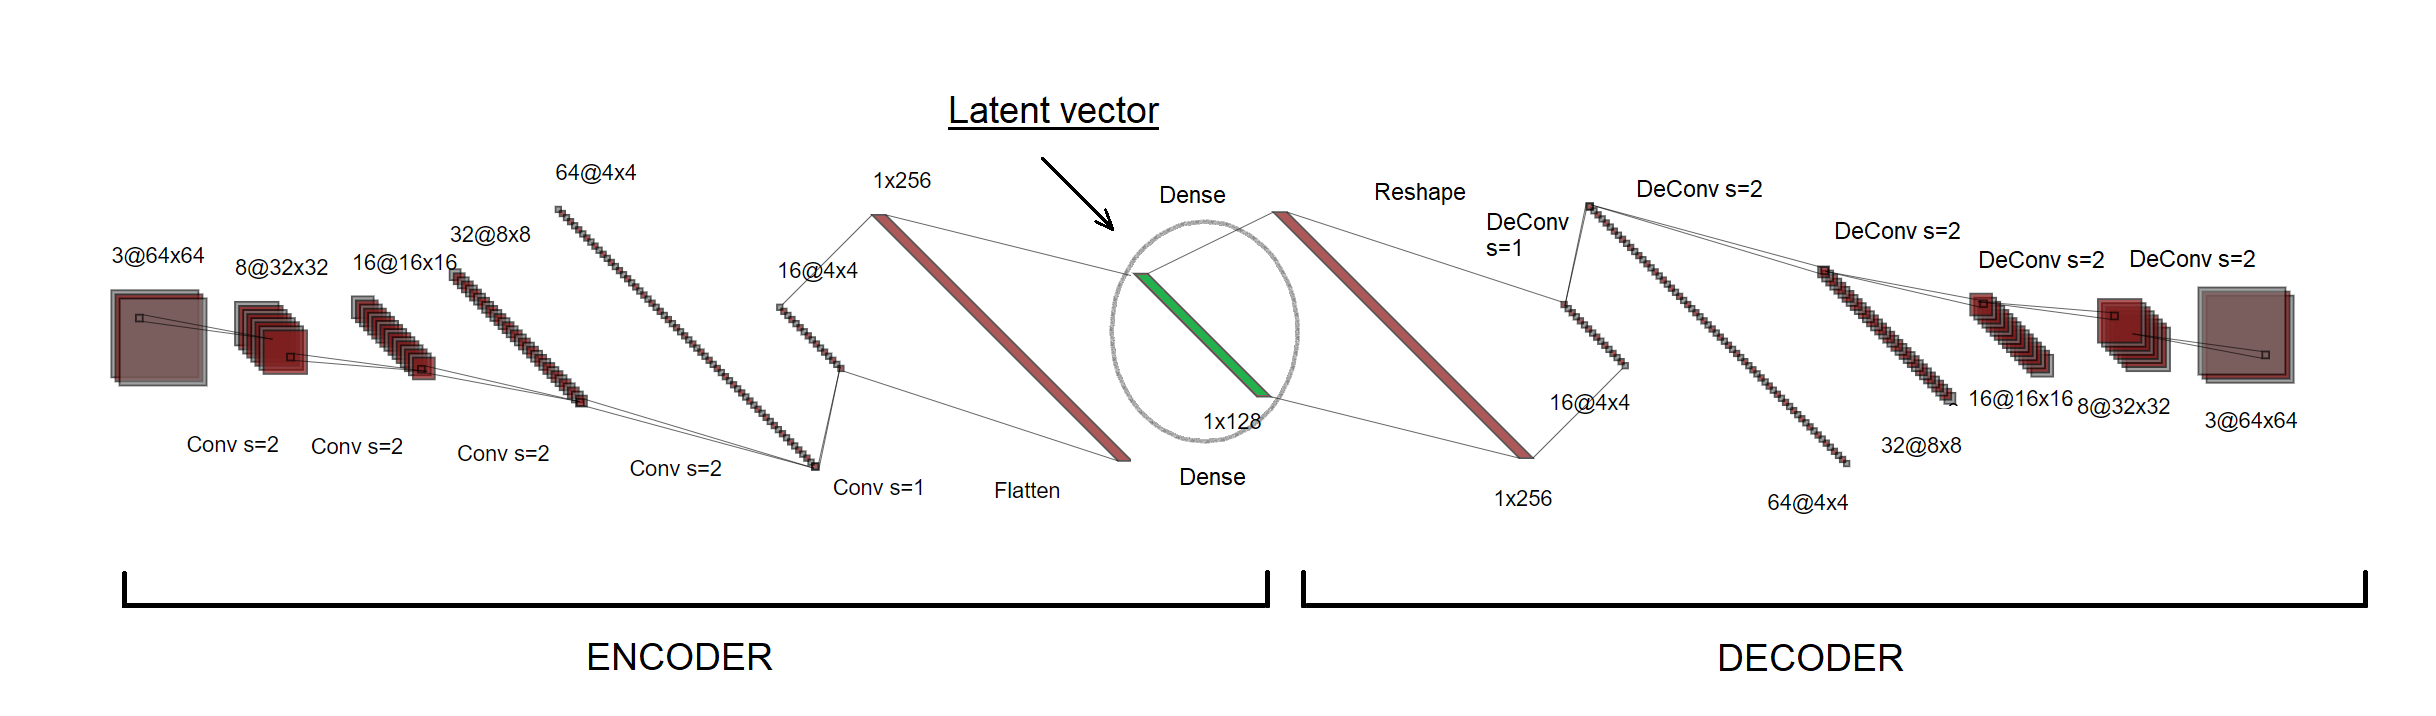

Instantiate the model, compile and fit:

In [ ]:
model = AutoEncoder(depth = 3)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())
model.fit(train_data, epochs=20)

In [ ]:
model.save_weights(WEIGHTS_PATH)

In [ ]:
model.load_weights(WEIGHTS_PATH)

# Anomaly detection

### General introduction to the task

The autoencoder learns how to reconstruct an image, but this only applies on images that the model saw, not on different ones. In this case the model is trained only on healthy data and will prefectly (almost) reconstruct them, but it is not able to reconstruct parasitized data. An example is shown in the cells below.

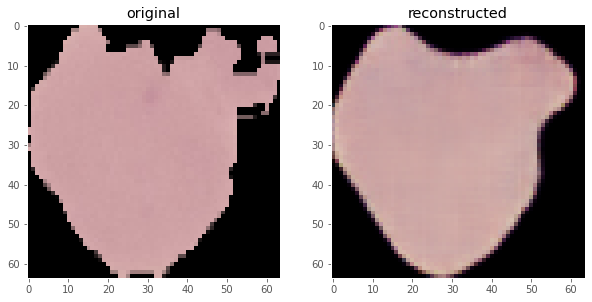

In [ ]:
#@title Healthy cell
bdos.plot_imgs(val_data_healthy.shuffle(1000), model)

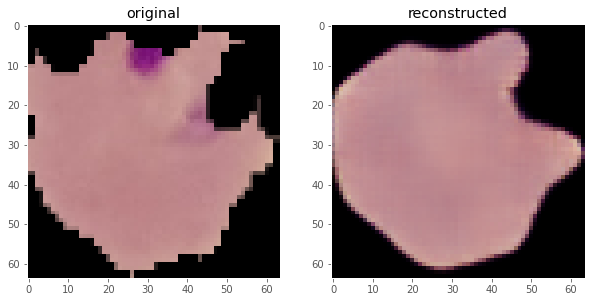

In [ ]:
#@title Parasitized cell
bdos.plot_imgs(val_data_malaria.shuffle(1000), model)

As it is possible to notice healthy cells are reconstruced almost exactly meanwhile the parasitized ones are reconstructed without the "sick part".
From this difference it comes the method to detect an anomaly: it is possible to classify the data as anomalous if the difference between the original data and the reconstructed one is above a certain threshold, i.e.:
$$
\text{distance}(x,x_r) > t
$$
where the distance should not always be interpreted rigourosly. \\
The idea comes from the fact that for normal data this distance would be smaller rather than anomalous data.
Since the difference between the real image and the reconstructed one is in the parasitized part, by also plotting this difference as an image it is possible to highlight the sick part. \\
As an extra feature the autoencoder smoothens the borders of the cell, infact these particular type of models are also used to denoise images (Goodfellow 2016 https://www.deeplearningbook.org/). \\
This last feature seems to help our task but in reality is the only thing that is causing problems. \\
In the next cell it is shown the difference between one parasitized image and the reconstructed one.

Text(0.5, 1.0, 'difference')

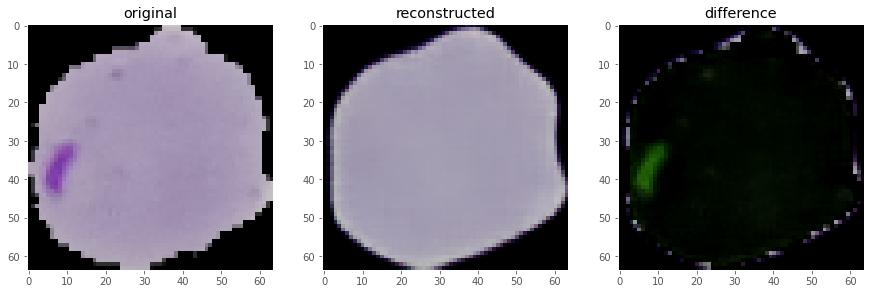

In [ ]:
#@title Plot of original image and difference between it and the reconstructed image
original_img = next(iter(val_data_malaria.shuffle(1000).batch(1)))
reconstructed_img = model(original_img)
diff = reconstructed_img - original_img
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(original_img[0])
plt.grid(False)
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(reconstructed_img[0])
plt.grid(False)
plt.title('reconstructed')
plt.subplot(1,3,3)
plt.imshow(diff[0])
plt.grid(False)
plt.title('difference')

From the example above we can notice that in the infected area *there is* a difference in pixels that we can exploit to detect anomalies, but also there is a difference in the borders of the cell, that is caused by the smoothening effect of the autoencoder. \\
These border pixels are hard to delete and their contribution is very high because those points are given by the difference of pixels with values $[0,0,0]$ and pixels greater than zero (the pink/purple color). They create a certain amount of noise which value is comparable to the signal we are looking for. \\
Without post processing, as will be shown in the following cells, it is impossible to detect correctly anomalies.

### Raw squared distance

Now it will be shown an approach without post image processing by taking as the distance measure $d$ the pixelwise mean squared error. 

Compute the distances for both healthy and parasitized data:

In [ ]:
'''
The ImagePostProcessing class performs the post-processing part and computes the distance
between the original data and the reconstructed one. By passing process=True it will compute
all the post-processing steps and with False it will just return the simple squared distance.
'''
post_processing = bdos.ImagePostProcessing(model, process=False)
healthy_distance = post_processing.compute_diff(val_data_healthy.batch(BATCH_SIZE))
malaria_distance = post_processing.compute_diff(val_data_malaria.batch(BATCH_SIZE))

The following histograms are computed on the differences between original data and their respective reconstructions. Ideally the two classes should have a well defined separation, but this is not the case. \\
Here and after the fine tuning will be performed by the analysis of the validation set.

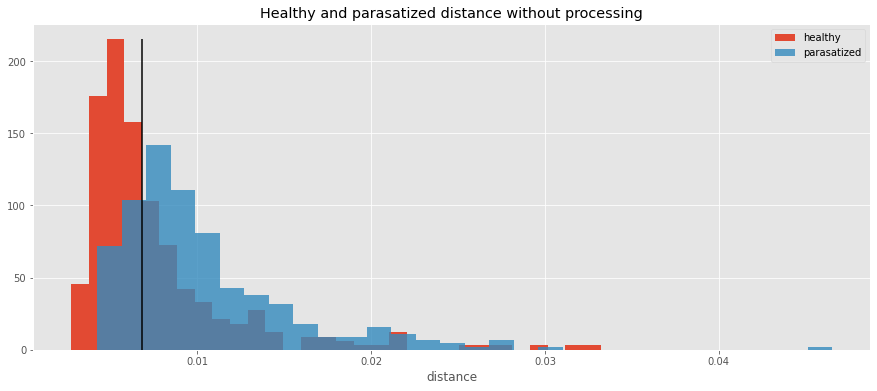

In [ ]:
#@title Plot histograms of distances for healthy and parasitized cells
fig, ax = plt.subplots(figsize=[15, 6])

ax.hist(healthy_distance, bins=30, density=True, 
label='healthy')
ax.hist(malaria_distance, bins=30, alpha=0.8, density=True, label='parasatized')
ax.vlines(0.9*np.mean(healthy_distance), ymin=0, ymax=215)
ax.legend()

plt.title('Healthy and parasatized distance without processing')
plt.xlabel('distance')

plt.show()

We can select a simple threshold as a value that is close to the mean  of the healthy distances (which approximately better splits the two classes).

In [ ]:
#@title Raw distance approach scores
anomaly_tr = np.mean(healthy_mae)*0.9
fp = len(healthy_mae[healthy_mae > anomaly_tr])/len(healthy_mae)
tn = len(healthy_mae[healthy_mae <= anomaly_tr])/len(healthy_mae)
tp = len(malaria_mae[malaria_mae > anomaly_tr])/len(malaria_mae)
fn = len(malaria_mae[malaria_mae <= anomaly_tr])/len(malaria_mae)
acc = (tp+tn)*0.5
print(f'True positive {tp:.2f} \nTrue negative {tn:.2f}\nFalse negative {fn:.2f} \nFalse positive {fp:.2f}\nAccuracy {acc:.2f}')

True positive 0.78 
True negative 0.61
False negative 0.22 
False positive 0.39
Accuracy 0.69


As it is possible to notice both from the histogram and the metrics, without any post processing we get poor results. 

### Image post-processing

The processing is composed by different steps: \\
1. Take the maximum between zero and the difference between the reconstructed image and the original image. This allows to always keep the signal we are looking for and cut some of the values of the borders. For all next points we will work with this difference.
2. Set to zero all pixels which values are in range of the background of the cells, i.e. set to zero the pixel if the value is greater than [0.83, 0.65 , 0.62 ] - $\alpha$, where $\alpha$ is subtracted to keep into account the broad variety of the colors that can appear as background in a cell and in this case is 0.6.
3. Apply a median filter with kernel size 5 to reduce the effect of the border (since they are mostly given by 1-2 pixels).
4. The signal is mostly given by the green color, for this reason all the values in the other channels are set to zero by applying on the pixels the mask [0,1,0].
5. Set one pixel to zero if its values are all less than 0.1 and greater than 0.45. This again is needed to delete some noise and delete colors that are too intense. 
6. After the previous points very few pixels remain, and since the borders are mostly given by 1-2 pixels we can further clean the signal by setting to zero all pixels of an image if the number of pixels different from zero in it are less than $\beta$ , that here is 10. 
7. As last step a mean filter with kernel size 7 is applied and the image is evaluated to the 1/1000 th power to increase the size and intensity of color of the highlighted region. \\
At the end the mean of all pixels is taken. \\

All the different parameters were fine tuned to get the best score. 

In the next cells an animation shows all the processing steps starting from the initial data until the final step.

In [ ]:
#@title Animation showing the post processing for healthy cell
processed_healthy_diffs = bdos.save_post_processing(val_data_healthy.shuffle(1000).batch(1), 
                                                    model)
HTML(bdos.generate_gif(processed_healthy_diffs).to_html5_video())

In [ ]:
#@title Animation showing post processing steps for parasitized cell
processed_parasatized_diffs = bdos.save_post_processing(val_data_malaria.shuffle(1000).batch(1),
                                                        model)
HTML(bdos.generate_gif(processed_parasatized_diffs).to_html5_video())

In the following cells the distances are computed with the post processing and the threshold $t$ is selected as the quantile of the distances of healthy data at a level of 0.913, that is giving the best value according to the used metrics.

Compute the distances for healthy and parasitized data with the post-processing approach:

In [ ]:
post_processing = bdos.ImagePostProcessing(model, process=True)
healthy_mae = post_processing.compute_diff(val_data_healthy.batch(BATCH_SIZE))
malaria_mae = post_processing.compute_diff(val_data_malaria.batch(BATCH_SIZE))

Selection of the threshold:

In [ ]:
anomaly_tr = np.quantile(healthy_mae, q = 0.913)

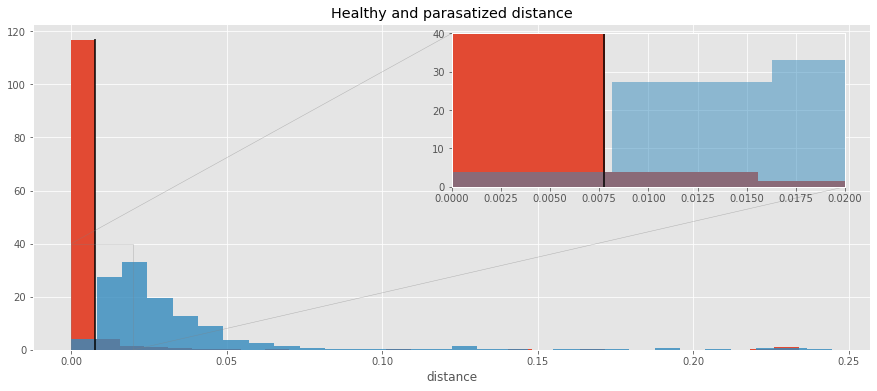

In [ ]:
#@title Histograms showing the healthy and parasitized distances with post processing.
fig, ax = plt.subplots(figsize=[15, 6])

ax.hist(healthy_mae, bins=30, density=True, )
ax.hist(malaria_mae, bins=30, alpha=0.8, density=True)
ax.vlines(anomaly_tr, ymin=0, ymax=117)

axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.hist(healthy_mae,bins=30 ,density=True)
axins.hist(malaria_mae, bins=30, alpha=0.5, density=True)
axins.vlines(anomaly_tr, ymin=0, ymax=117)

x1, x2, y1, y2 = 0.0, 0.02,0,40
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins)

plt.title('Healthy and parasitized distance')
plt.xlabel('distance')
plt.show()

In [ ]:
#@title Image post-processing approach metrics
fp = len(healthy_mae[healthy_mae > anomaly_tr])/len(healthy_mae)
tn = len(healthy_mae[healthy_mae <= anomaly_tr])/len(healthy_mae)
tp = len(malaria_mae[malaria_mae > anomaly_tr])/len(malaria_mae)
fn = len(malaria_mae[malaria_mae <= anomaly_tr])/len(malaria_mae)
acc = (tp+tn)*0.5
print(f'True positive {tp:.2f} \nTrue negative {tn:.2f}\nFalse negative {fn:.2f} \nFalse positive {fp:.2f}\nAccuracy {acc:.2f}')

True positive 0.97 
True negative 0.91
False negative 0.03 
False positive 0.09
Accuracy 0.94


With the post processing and this choice of $t$ we can get a good score. Between the anomalous data only 3% are not getting recognized by the model and around 10% of normal data get reported as anomaly. In this task is more important to have a low false negative rate rather than other measures, since a system like this one can be used as an alarm that reports suspicious cases that then can be examinated by an expert.

In the next cells some examples of highlighting of the parasitized part.

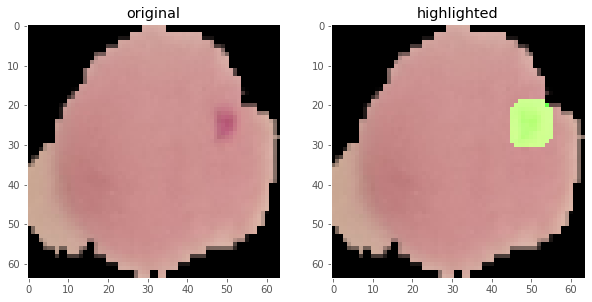

In [ ]:
#@title Highlight of the parasitized part of the cell
bdos.plot_diff(val_data_malaria.shuffle(1000), model)

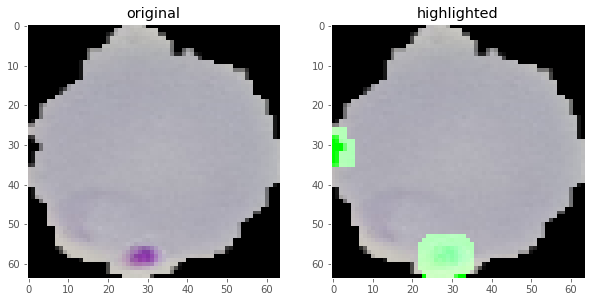

In [ ]:
#@title Highlight of the parasitized part of the cell
bdos.plot_diff(val_data_malaria.shuffle(1000), model)

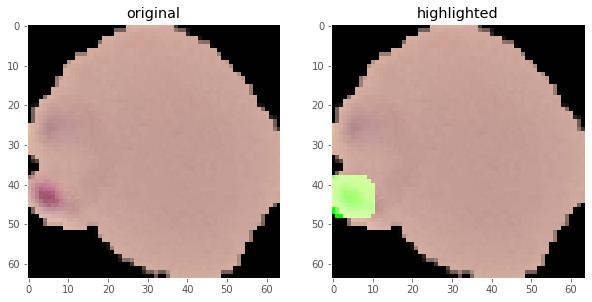

In [ ]:
#@title Highlight of the parasitized part of the cell
bdos.plot_diff(val_data_malaria.shuffle(1000), model)

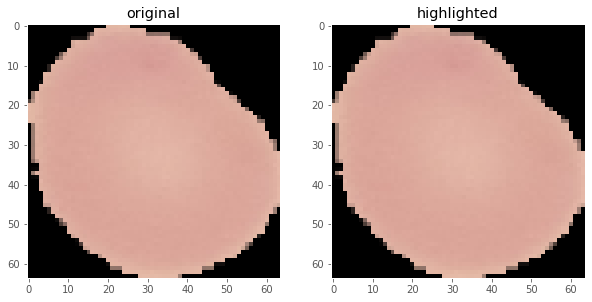

In [ ]:
#@title Post processing on normal cell
bdos.plot_diff(val_data_healthy.shuffle(1000), model)

# Model diagnostics

The main problem is given by the residual pixels that remain when taking the distance between the real image and the reconstructed one. This is specially accentuated for the anomalous data for the consequence of the point 6 in the post processing since in healthy data is more difficult to find a large group of pixels different from zero. But if the number of pixels is larger than $\beta$ then the healthy data appears as anomalous since the instensity of those few random pixels is increased.

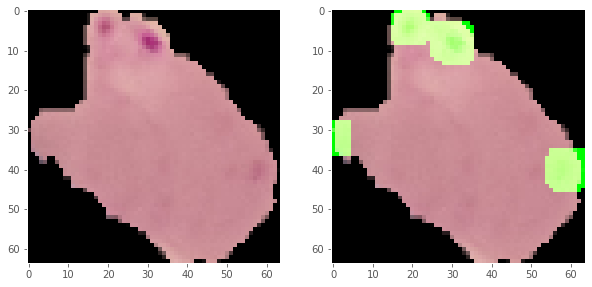

In [ ]:
#@title Example of eccessive highlighting for anomalous data
bdos.plot_diff(val_data_malaria.shuffle(1000), model)

In [ ]:
#@title Gif showing eccessive highlighting on normal cell
processed_healthy_diffs = bdos.save_post_processing(val_data_healthy.shuffle(1000).batch(1), 
                                                    model)
HTML(bdos.generate_gif(processed_healthy_diffs).to_html5_video())

A solution to the previous problem can be in a better data pre / post processing, by trying to smoothen the effect of the borders. 

Another type of problems is given by "anomalous" healthy cells, i.e. cells with strange dark spots that the autoencoder cannot reconstruct and which lead to false positives. A solution to this problem could be to increase the dataset with more data of this type.

In [ ]:
#@title Gif showing post processing on a false positive data with anomalous spots
processed_healthy_diffs = bdos.save_post_processing(val_data_healthy.shuffle(1000).batch(1), 
                                                    model)
HTML(bdos.generate_gif(processed_healthy_diffs).to_html5_video())

# Interpretability of the latent space

The data embedded in the latent space could have some meaning. The idea here was taken by (https://thilospinner.com/towards-an-interpretable-latent-space/) and essentially is to perform a PCA on the encoded dataset and plot the first 2 components.

Function that takes the data and computes the PCA:

In [ ]:
from sklearn.decomposition import PCA

def pca_on_latent_vectors(data):
    '''
        Function that takes in input a dataset and performs a 
        PCA on the embedded images.
        Returns the data in the latent space and the transformation.
    '''
    latent_vecs = []
    for imgs in data.batch(BATCH_SIZE):
        encoded_var = model.Encoder(imgs)
        latent_vecs = latent_vecs + [row for row in encoded_var]

    latent_vecs = np.array(latent_vecs)
    pca = PCA(2)
    transformed_latent_vecs = pca.fit_transform(latent_vecs)
    return latent_vecs,transformed_latent_vecs

In [ ]:
latent_healthy, transformed_latent_healthy = pca_on_latent_vectors(val_data_healthy)
latent_malaria, transformed_latent_malaria = pca_on_latent_vectors(val_data_malaria)

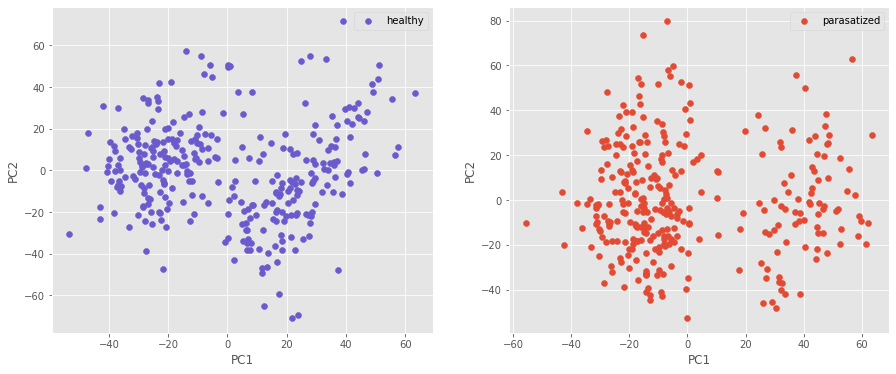

In [ ]:
#@title Plot the first 2 principal components for healthy and parasitized data
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(transformed_latent_healthy[:,0], 
            transformed_latent_healthy[:,1], 
            label='healthy', c='slateblue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(transformed_latent_malaria[:,0], 
            transformed_latent_malaria[:,1], 
            label='parasitized')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Surprisingly there is a clear subdivision for both data along the PC1. It seems that this division is at value PC1 = 0. We can plot different images and for each of those print the value of the first principal component.

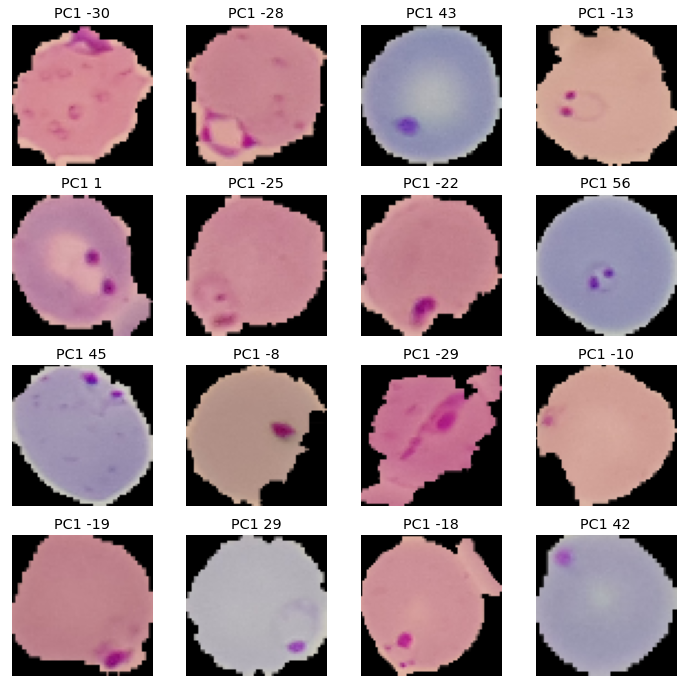

In [ ]:
#@title Cell images and value of PC1 for parasitized data
plt.figure(figsize=(12,12))
for i, img in zip(range(16), val_data_malaria):
    plt.subplot(4,4,i+1)
    #decoded_img = model.Decoder(latent_malaria[i].reshape(1,-1))
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'PC1 {transformed_latent_malaria[i,0]:.0f}')
    plt.xticks([])
    plt.yticks([])

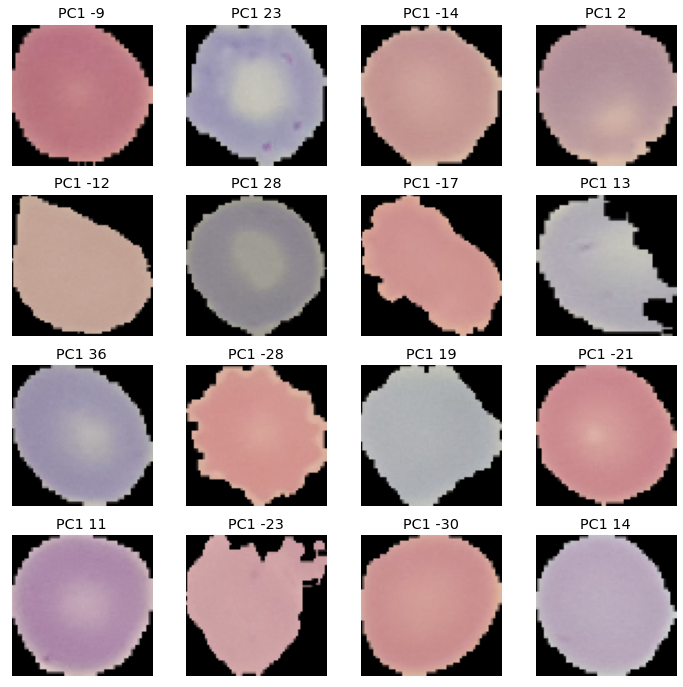

In [ ]:
#@title Cell images and value of PC1 for healthy data
plt.figure(figsize=(12,12))
for i, img in zip(range(16), val_data_healthy):
    plt.subplot(4,4,i+1)
    #decoded_img = model.Decoder(latent_healthy[i].reshape(1,-1))
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'PC1 {transformed_latent_healthy[i,0]:.0f}')
    plt.xticks([])
    plt.yticks([])

Clearly the value of the first principal component is associated to the color. More in detail: negative values are associated to the pink and the positive values are associated to the purple. The first principal component in the latent space is then most likely associated to the color of the cell. 